<a href="https://colab.research.google.com/github/guevelel/COMP4449_Image_Classification/blob/main/Traffic_Signs_COMP4449.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# COMP4449 Midterm - Traffic Sign Image Classification
## Edward Guevel


### Recognizing Traffic Signs
The goal of this project is to build a model capable of determining the type of traffic sign that is displayed in an image captured under different real-life conditions and showing obstructions, poor lighting, or even the sign being far away from the camera. We provide you with labeled images already splited in three files (tran/val/test) and a predefined list of signs to recognise. 

In [ ]:
#Questions:
#What are the size, and coords features in the dataset?
#Boost the distribution to be even using the random image generator?
#Update error analysis accordingly


#use random number generator to mimic incoming image?

In [ ]:
#%pip install torchmetrics


### Data Import and Preparation

In [ ]:
#Import required libraries:
import pandas as pd
import pickle
import zipfile
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import cv2
import numpy as np
import matplotlib.pyplot as plt
import torch
import tensorflow as tf 
from keras.models import Sequential 
from keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout, AveragePooling2D
from keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import mean_squared_error, accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.metrics import roc_curve
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense

In [ ]:
# Download and unzip
dataroot = "dataroot/"
!mkdir dataroot 
!wget -P dataroot https://raw.githubusercontent.com/emmanueliarussi/DataScienceCapstone/master/3_MidtermProjects/ProjectRTS/data/data_1.zip
!wget -P dataroot https://raw.githubusercontent.com/emmanueliarussi/DataScienceCapstone/master/3_MidtermProjects/ProjectRTS/data/data_2.zip
!wget -P dataroot https://raw.githubusercontent.com/emmanueliarussi/DataScienceCapstone/master/3_MidtermProjects/ProjectRTS/data/data_3.zip 

mkdir: cannot create directory ‘dataroot’: File exists
--2023-04-14 02:00:45--  https://raw.githubusercontent.com/emmanueliarussi/DataScienceCapstone/master/3_MidtermProjects/ProjectRTS/data/data_1.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 32074743 (31M) [application/zip]
Saving to: ‘dataroot/data_1.zip.1’

data_1.zip.1        100%[===================>]  30.59M   123MB/s    in 0.2s    

2023-04-14 02:00:46 (123 MB/s) - ‘dataroot/data_1.zip.1’ saved [32074743/32074743]

--2023-04-14 02:00:46--  https://raw.githubusercontent.com/emmanueliarussi/DataScienceCapstone/master/3_MidtermProjects/ProjectRTS/data/data_2.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to r

In [ ]:
# Unzip github files into colab folders:
with zipfile.ZipFile(dataroot+"data_1.zip","r") as zip_ref:
    zip_ref.extractall(dataroot)
with zipfile.ZipFile(dataroot+"data_2.zip","r") as zip_ref:
    zip_ref.extractall(dataroot)
with zipfile.ZipFile(dataroot+"data_3.zip","r") as zip_ref:
    zip_ref.extractall(dataroot)

In [ ]:
# Load sign names into a dictionary:
df = pd.read_csv("https://raw.githubusercontent.com/emmanueliarussi/DataScienceCapstone/master/3_MidtermProjects/ProjectRTS/data/signnames.csv")
signnames = pd.Series(df.SignName.values,index=df.ClassId).to_dict()
#signnames
#signnames.values()

In [ ]:
# Load training, validation, and testing images:
train = pickle.load( open( dataroot+"train.p", "rb" ) )
val = pickle.load( open( dataroot+"valid.p", "rb" ) )
test = pickle.load( open( dataroot+"test.p", "rb" ) )

print(train.keys())
type(train)


dict_keys(['coords', 'labels', 'features', 'sizes'])


dict

In [ ]:
for i in range(20):
  print(train['coords'][i])

#for i in range(20):
#  print(train['sizes'][i])

[ 6  5 21 20]
[ 6  6 22 22]
[ 5  6 22 23]
[ 5  6 22 23]
[ 5  6 23 23]
[ 6  5 25 23]
[ 6  5 25 25]
[ 5  5 25 25]
[ 6  5 26 25]
[ 6  5 27 26]
[ 6  6 28 28]
[ 6  5 29 28]
[ 6  5 29 28]
[ 5  6 29 30]
[ 6  5 31 31]
[ 5  5 31 32]
[ 6  6 33 34]
[ 5  5 32 33]
[ 5  6 33 35]
[ 6  5 36 36]


The image shows a Turn left ahead sign


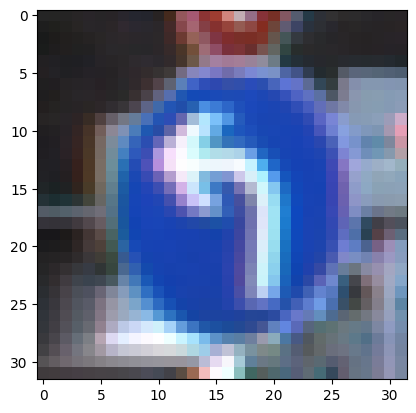

In [ ]:
# Preview random image:
inx = 20123
plt.imshow(train['features'][inx])
print("The image shows a {} sign".format(signnames[train['labels'][inx]]))

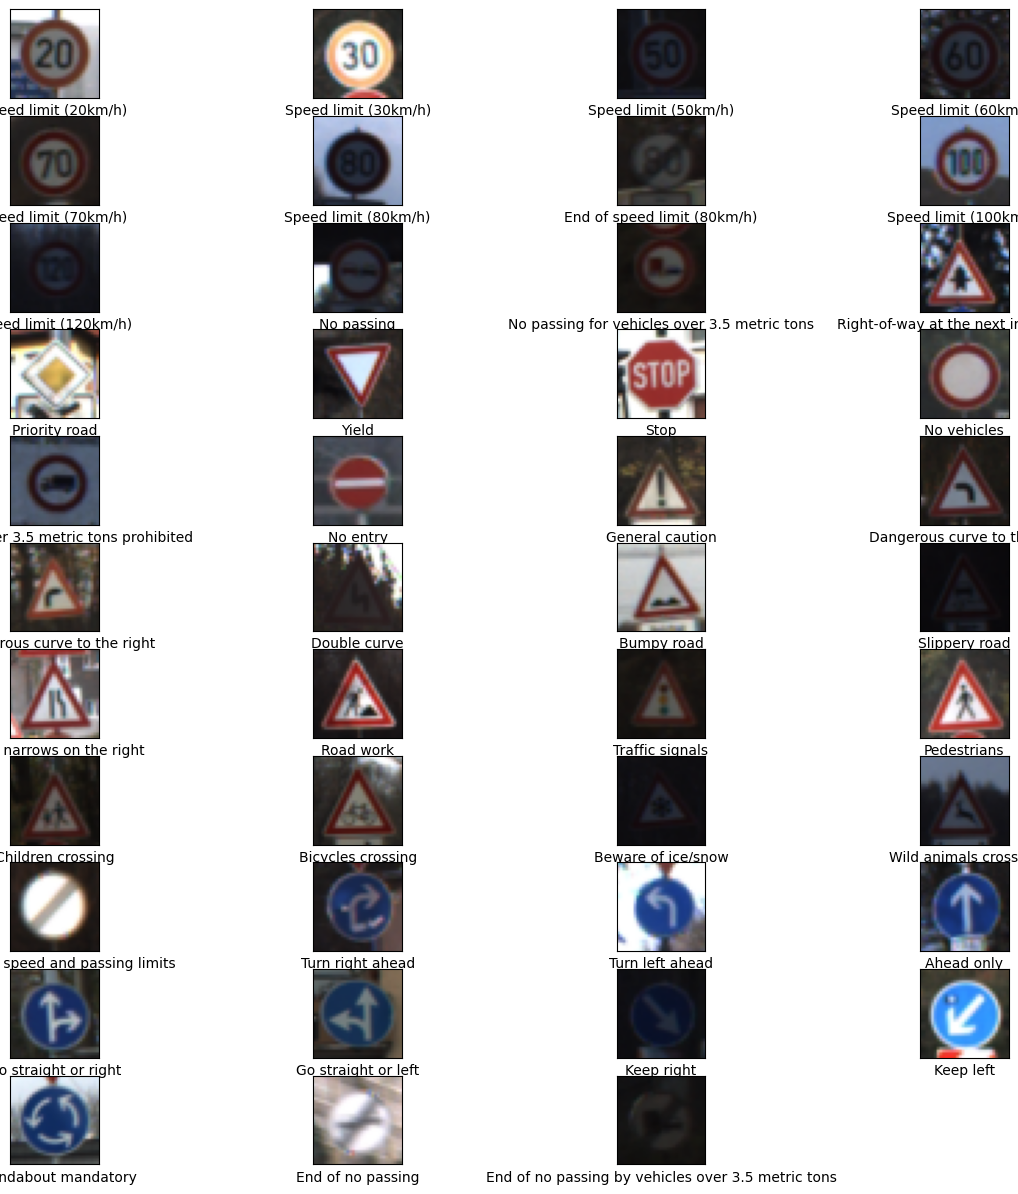

In [ ]:
#Visualize all of the different road signs:
plt.figure(figsize=(15,15))
for i in range(43):
  plt.subplot(11,4,i+1)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  titles = np.where(train['labels']==i)
  index = titles[0][50]
  plt.imshow(train['features'][index], cmap=plt.cm.binary)
  plt.xlabel(signnames[train['labels'][index]])
plt.show()

Now we will look at the distribution of the entire dataset to see the frequency of each of the 43 distinct labels.

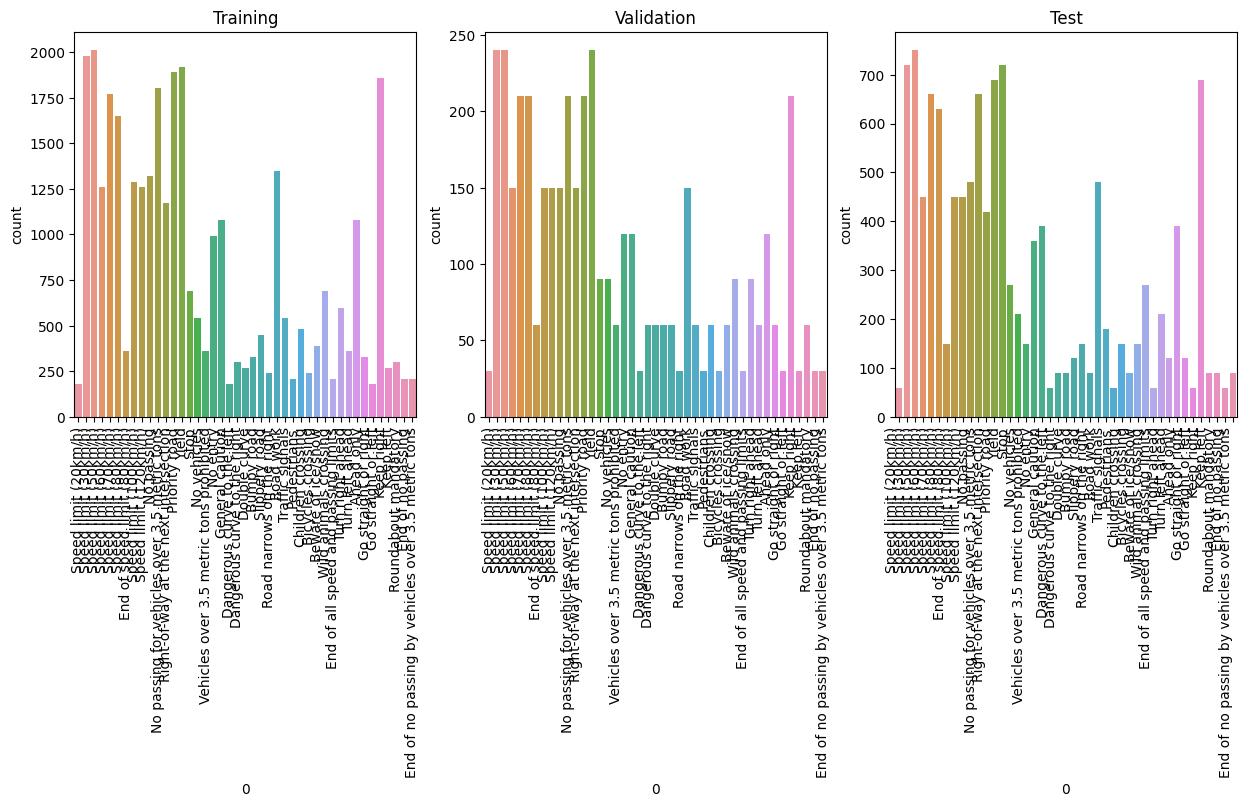

In [ ]:
#Plot the distributions of the training, validation, and test data:

#Convert data to DF:
data_train = pd.DataFrame(train['labels'])
data_val = pd.DataFrame(val['labels'])
data_test = pd.DataFrame(test['labels'])

#Generate countplots:
fig, ax =plt.subplots(1,3, figsize=(15,5))
sns.countplot(data_train, x=data_train[0], ax=ax[0])
ax[0].set_title('Training')
ax[0].set_xticklabels(list(signnames.values()))
for tick in ax[0].get_xticklabels():
    tick.set_rotation(90)

sns.countplot(data_val, x=data_val[0], ax=ax[1])
ax[1].set_title('Validation')
ax[1].set_xticklabels(list(signnames.values()))
for tick in ax[1].get_xticklabels():
    tick.set_rotation(90)

sns.countplot(data_test, x=data_test[0], ax=ax[2])
ax[2].set_title('Test')
ax[2].set_xticklabels(list(signnames.values()))
plt.xticks(rotation=90, ha='right')

plt.show()

We can see above that the distribution of labels throught the dataset widely varies across the 43 distinct labels (different signs). 

In [ ]:
#look at count distributions
counts = pd.DataFrame(columns = ['index', 'count', 'label'])
for i in range(43):
  titles = np.where(train['labels']==i)
  counts.loc[len(counts.index)] = [i, len(titles[0]), signnames[i]] 
counts


,index,count,label
0,0,180,Speed limit (20km/h)
1,1,1980,Speed limit (30km/h)
2,2,2010,Speed limit (50km/h)
3,3,1260,Speed limit (60km/h)
4,4,1770,Speed limit (70km/h)
5,5,1650,Speed limit (80km/h)
6,6,360,End of speed limit (80km/h)
7,7,1290,Speed limit (100km/h)
8,8,1260,Speed limit (120km/h)
9,9,1320,No passing


### Split the data into Training, Validation, and Test sets
Here we will also normalize all of the image array values to be a float value between 0 and 1 instead of integers between 0 and 225. The image normalization is required for feeding the image arrays into a Convolutional Neural Network.

In [ ]:
#Split out data into training, validation, and test sets:
X_train = train['features']
y_train = train['labels']
X_val = val['features']
y_val = val['labels']
X_test = test['features']
y_test = test['labels']

#need to normalize images to feed into NN:
X_train = X_train / 255.0
X_val = X_val / 255.0
X_test = X_test / 255.0

# Reshape and one hot encode:
y_train = tf.one_hot(y_train, 43)
y_val = tf.one_hot(y_val, 43)
y_test = tf.one_hot(y_test, 43)

#Check the shape of each data set:
print ("number of training examples = " + str(X_train.shape[0]))
print ("number of test examples = " + str(X_test.shape[0]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(y_train.shape))
print ("X_val shape: " + str(X_val.shape))
print ("Y_val shape: " + str(y_val.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(y_test.shape))

number of training examples = 34799
number of test examples = 12630
X_train shape: (34799, 32, 32, 3)
Y_train shape: (34799, 43)
X_val shape: (4410, 32, 32, 3)
Y_val shape: (4410, 43)
X_test shape: (12630, 32, 32, 3)
Y_test shape: (12630, 43)


Now, the shape of our data is (34799, 32, 32, 3), where 34799 represents the number of images,32*32 represents the image sizes into pixels, and the last 3 represents the RGB value(availability of coloured data).

In [ ]:
#Convert feature image arrays to tensors:
X_train_tensor = tf.convert_to_tensor(X_train)
X_val_tensor = tf.convert_to_tensor(X_val)
X_test_tensor = tf.convert_to_tensor(X_test)
#print(X_train_tensor)

In [ ]:
#Convert data to tensors and move to GPU for faster computing
#setup device agnostoc code
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

#X_train = torch.from_numpy(X_train).type(torch.float32)
#X_train = torch.Tensor(X_train)
#X_train = X_train.to(device)
#X_val = torch.from_numpy(X_val).type(torch.float32)
#X_val = torch.Tensor(X_val)
#X_val= X_val.to(device)
#X_test = torch.from_numpy(X_test).type(torch.float32)
#X_test = torch.Tensor(X_test)
#X_test = X_test.to(device)

#y_train = y_train.to(device)
#y_val = y_val.to(device)
#y_test = y_test.to(device)

#print(X_train.shape, type(X_train), X_train.device)

cuda


In [ ]:
#X_train = torch.from_numpy(X_train)
#X_train = X_train.to(device)
#print(X_train.shape, type(X_train), X_train.device)

### Model Building

We will start with the basic framework for a LeNet-5 Image Classification Convolutional Neural Network. We will have to adjust the input size to (32, 32, 3) to match the shape of our input images. We will also adjust the softmax output layer to have 43 distinct values to match the number of distinct traffic sign labels in our dataset. 

In [ ]:
#Build Neural Network Model: 
tf.random.set_seed(42)
np.random.seed(42)

#Using an existing LeNet-5 Neural Network framework for image classification as baseline model
#LeNet-5 
model = Sequential()
model.add(Conv2D(filters=5, kernel_size=(5,5), activation='relu', padding='valid', input_shape=X_train_tensor.shape[1:]))
model.add(AveragePooling2D(pool_size=(2,2),strides=2,padding='valid',data_format=None,)) #is this right?
model.add(Conv2D(filters=5, kernel_size=(5,5), activation='relu', padding='valid'))
model.add(AveragePooling2D(pool_size=(2,2),strides=2,padding='valid',data_format=None,)) #is this right?
model.add(Flatten())
model.add(Dense(120, activation='relu'))
model.add(Dense(84, activation='relu'))
model.add(Dense(43, activation='softmax'))

#Compile the model:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

#Dense layers are fully connected
#Convolutional, Pooling, LSTM
#Dropout
#Flatten
#Reshape
#Pooling
#Convolutional


In [ ]:
#Set number of Epochs:
eps = 12

#Fit model and track the accuracy and loss:
#history = model.fit(X_train, y_train, batch_size=32, epochs=eps, validation_data=(X_val, y_val))
history = model.fit(X_train_tensor, y_train, batch_size=32, epochs=eps, validation_data=(X_val_tensor, y_val))

Epoch 1/12
1088/1088 [==============================] - 17s 6ms/step - loss: 1.3463 - accuracy: 0.6353 - val_loss: 0.7273 - val_accuracy: 0.7909
Epoch 2/12
1088/1088 [==============================] - 5s 5ms/step - loss: 0.3930 - accuracy: 0.8893 - val_loss: 0.5577 - val_accuracy: 0.8376
Epoch 3/12
1088/1088 [==============================] - 6s 5ms/step - loss: 0.2412 - accuracy: 0.9328 - val_loss: 0.5866 - val_accuracy: 0.8492
Epoch 4/12
1088/1088 [==============================] - 5s 5ms/step - loss: 0.1751 - accuracy: 0.9518 - val_loss: 0.6092 - val_accuracy: 0.8603
Epoch 5/12
1088/1088 [==============================] - 6s 6ms/step - loss: 0.1341 - accuracy: 0.9630 - val_loss: 0.4640 - val_accuracy: 0.8873
Epoch 6/12
1088/1088 [==============================] - 6s 5ms/step - loss: 0.1049 - accuracy: 0.9704 - val_loss: 0.5012 - val_accuracy: 0.8934
Epoch 7/12
1088/1088 [==============================] - 7s 7ms/step - loss: 0.0866 - accuracy: 0.9752 - val_loss: 0.4762 - val_accuracy

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 5)         380       
                                                                 
 average_pooling2d (AverageP  (None, 14, 14, 5)        0         
 ooling2D)                                                       
                                                                 
 conv2d_1 (Conv2D)           (None, 10, 10, 5)         630       
                                                                 
 average_pooling2d_1 (Averag  (None, 5, 5, 5)          0         
 ePooling2D)                                                     
                                                                 
 flatten (Flatten)           (None, 125)               0         
                                                                 
 dense (Dense)               (None, 120)               1

The history.history["loss"] entry is a dictionary with as many values as epochs that the model was trained on. 

       loss  accuracy  val_loss  val_accuracy
0  1.346326  0.635277  0.727254      0.790930
1  0.393002  0.889307  0.557663      0.837642
2  0.241180  0.932843  0.586626      0.849206
3  0.175115  0.951751  0.609191      0.860317
4  0.134058  0.962959  0.463988      0.887302


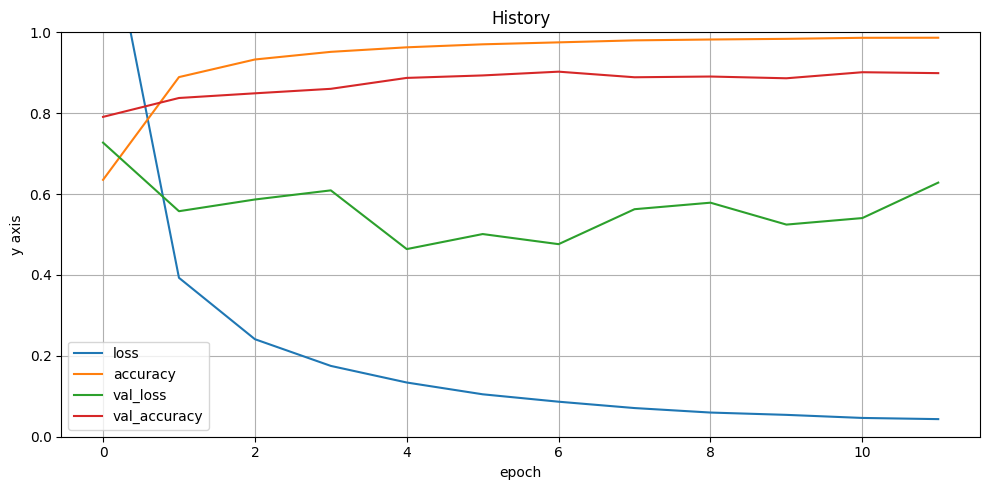

In [ ]:
# Plot the train and validation accuracy and loss curves:
#df_loss_acc = pd.DataFrame(history.history)
#df_loss= df_loss_acc[['loss','val_loss']]
#df_loss.rename(columns={'loss':'train','val_loss':'validation'},inplace=True)
#df_acc= df_loss_acc[['accuracy','val_accuracy']]
#df_acc.rename(columns={'accuracy':'train','val_accuracy':'validation'},inplace=True)
#df_loss.plot(title='Model loss',figsize=(4,4)).set(xlabel='Epoch',ylabel='Loss')
#df_acc.plot(title='Model Accuracy',figsize=(4,4)).set(xlabel='Epoch',ylabel='Accuracy')


#Plot the loss and accuracy v. Epoch
df=pd.DataFrame(history.history)
print(df.head())

fig,ax=plt.subplots(figsize=(10,5))
ax.plot(df['loss'], label='loss')
ax.plot(df['accuracy'], label='accuracy')
ax.plot(df['val_loss'], label='val_loss')
ax.plot(df['val_accuracy'], label='val_accuracy')
ax.legend(loc=0)
ax.set_title('History')
ax.set_xlabel('epoch')
ax.set_ylabel('y axis')
ax.set_ylim(0,1)
ax.grid()
plt.tight_layout()
plt.show()

In [ ]:
#Assess accuracy on Test set:
#model.evaluate(X_test, y_test)
model.evaluate(X_test_tensor, y_test)

395/395 [==============================] - 1s 3ms/step - loss: 0.7499 - accuracy: 0.8975


[0.7498970627784729, 0.8975455164909363]

In [ ]:
#Extract the model predictions on the test set (for confusion matrix building):
tf.random.set_seed(42)
np.random.seed(42)

#pred = model.predict(X_test)
pred = model.predict(X_test_tensor)
#pred

#Convert label matrices to index values for confustion matrix:
y_preds = []
for i in range(len(pred)):
  y_preds.append(np.argmax(pred[i]))
#y_preds

y_act = []
for i in range(len(y_test)):
  y_act.append(np.argmax(y_test[i]))
#y_act

#import torch
y_act =torch.Tensor(y_act)
y_preds = torch.Tensor(y_preds)

395/395 [==============================] - 1s 2ms/step


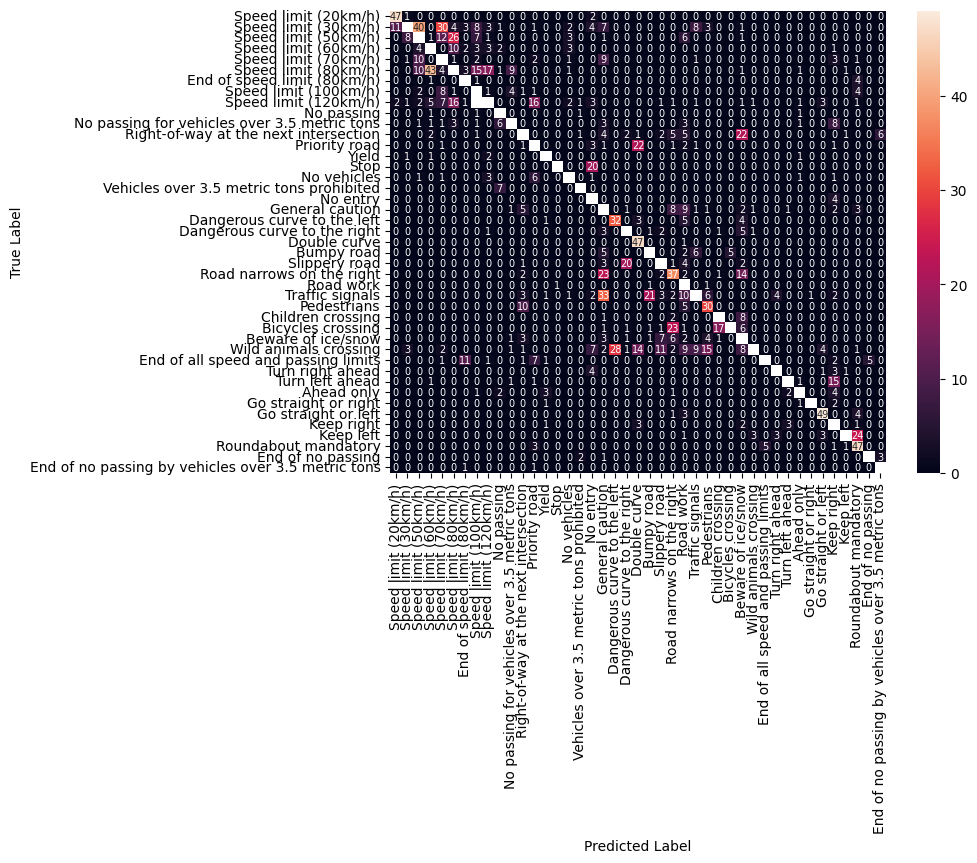

In [ ]:
#Plot heatmap of classification results (masking values >50 to point out misclassifications)
fig, ax = plt.subplots(figsize=(8,6))
corr = confusion_matrix(y_preds, y_act)
names = signnames.values()
#corr/np.sum(corr), fmt='.1%'
sns.heatmap(corr, annot=True,
            xticklabels=names,yticklabels=names, fmt='d',annot_kws={"size": 7},
            mask= corr >51)#,
            #cmap="Blues")

plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

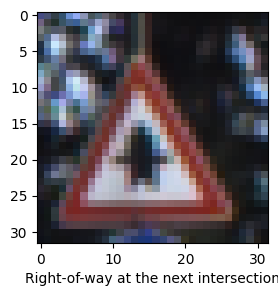

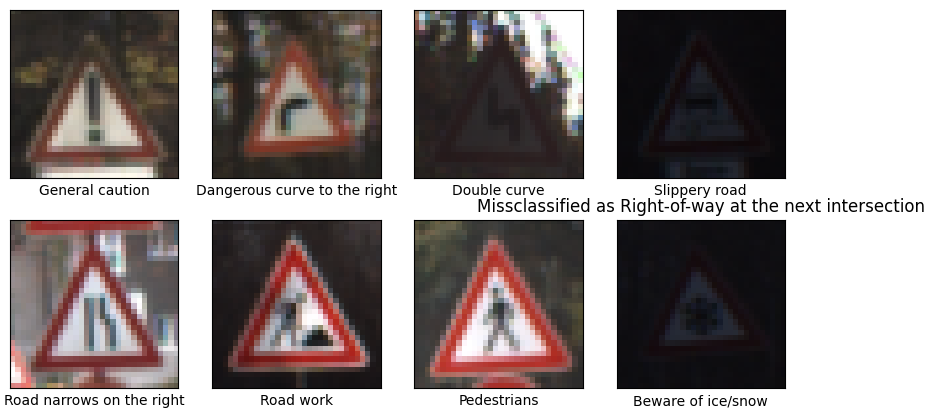

In [ ]:
#Error analysis:

#Look at 'Right-of-way at the next intersection' v (general caution and dangerous curve to the left) since those were mis-classified
#more frequently than others

error_pics = [18,20,21,23,24,25, 27, 30]
actual = [11] #Right-of-way at the next intersection Index

plt.figure(figsize=(3,3))
titles = np.where(train['labels']==actual)
index = titles[0][50]
plt.imshow(train['features'][index], cmap=plt.cm.binary)
plt.xlabel(signnames[train['labels'][index]])
plt.show()

plt.figure(figsize=(10,5))
#for i in range(len(error_pics)):
count = 1
for i in error_pics:
  plt.subplot(2,4,count)
  count+=1
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  titles = np.where(train['labels']==i)
  index = titles[0][50]
  plt.imshow(train['features'][index], cmap=plt.cm.binary)
  plt.xlabel(signnames[train['labels'][index]])

plt.title("Missclassified as Right-of-way at the next intersection")
plt.show()

#signnames


In [ ]:
#X_train = train['features']
#y_train = train['labels']
small = counts.index[counts['count'] <=500].tolist()
#small
#aggDf = pd.DataFrame(X_train[:][0])#, X_train[1], X_train[2])
#aggDf.head()
#for i in small:
#  print(i)
y_train[5]

0
6
16
19
20
21
22
23
24
27
28
29
30
32
34
36
37
39
40
41
42


In [61]:
#Data Augmentation:
#Rotating, zooming, etc. images
#this makes model more robust to new images it will attempt to classify. Not all images taken are perfect size, shape, etc. 

#extract labels that have less than 500 images:
small = counts.index[counts['count'] <=500].tolist()
#small


# set up data generator"
datagen = ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True,
    rotation_range=45,
    #brightness_range=[.9,10.0],
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.1, #slight zooming
    horizontal_flip=False, #no flipping
    vertical_flip = False)

# Fit the generator using your data:
datagen.fit(X_train)

batch_size = 32
train_generator = datagen.flow(X_train, y_train, batch_size=batch_size)
val_generator = datagen.flow(X_val, y_val, batch_size=batch_size)

#Augment the training data:
augmented = []
for i in range(len(X_train)):
  augmented.append(datagen.random_transform(X_train[i], seed = 42))

In [ ]:
#Combine rotated training images with actual training images increase training data size
X_train_enlarged = np.vstack((X_train, augmented))
#X_train_enlarged = torch.stack((augmented,X_train_tensor), dim=0)
print(X_train_enlarged.shape)

y_train_enlarged = np.vstack((y_train, y_train))#, y_train))
print(y_train_enlarged.shape)

In [ ]:
#Look at the updated distribution of the training data after adding augmented values
sns.countplot(X_train_enlarged, x=X_train_enlarged[0], ax=ax)
ax.set_title('Augmented Training Distribution')
ax.set_xticklabels(list(signnames.values()))
for tick in ax.get_xticklabels():
    tick.set_rotation(90)


In [ ]:
#Show Comparison of Images:
plt.subplot(1,2,1)
z = 4004
plt.imshow(augmented[z])
plt.subplot(1,2,2)
#plt.imshow(X_train[int(z/2)])
plt.imshow(X_train[z])

Note: I chose not to use the X_train_enlarged and Y_train_enlarged datasets from image augmentation. Instead I feed the image data augmentation flow into the model.fit() function to augment the images in realtime. This is a much more robust approach to image augmentation. 

In [ ]:
#Retrain Model with additional data:
tf.random.set_seed(42)
np.random.seed(42)
eps = 50

#LeNet-5 
model = Sequential()
model.add(Conv2D(filters=5, kernel_size=(5,5), activation='relu', padding='valid', input_shape=X_train.shape[1:]))
model.add(AveragePooling2D(pool_size=(2,2),strides=2,padding='valid',data_format=None,)) #is this right?
model.add(Conv2D(filters=5, kernel_size=(5,5), activation='relu', padding='valid'))
model.add(AveragePooling2D(pool_size=(2,2),strides=2,padding='valid',data_format=None,)) #is this right?
model.add(Flatten())
model.add(Dense(120, activation='relu'))
model.add(Dense(84, activation='relu'))
model.add(Dense(43, activation='softmax'))

#Compile the model:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

#Fit the model:
#Decided not to use the enlarged data augmented training set and used the real time data augmentation below
#history = model.fit(X_train_enlarged, y_train_enlarged, batch_size=32, epochs=eps, validation_data=(X_val, y_val))
#history = model.fit(train_generator, batch_size=32, epochs=eps, validation_data=(X_val, y_val))
#history = model.fit(datagen.flow(X_train, y_train, batch_size=32, subset='training'),
#         validation_data=datagen.flow(X_val, y_val, batch_size=32, subset='validation'),
#         steps_per_epoch=len(X_train) / 32, epochs=eps)

history = model.fit(train_generator, batch_size=32, epochs=eps, validation_data=val_generator)
#val_generator

Epoch 1/50
1088/1088 [==============================] - 34s 30ms/step - loss: 2.7985 - accuracy: 0.2151 - val_loss: 2.7578 - val_accuracy: 0.2268
Epoch 2/50
 296/1088 [=======>......................] - ETA: 21s - loss: 2.4268 - accuracy: 0.2957

In [ ]:
#Plot the loss and accuracy v. Epoch
df=pd.DataFrame(history.history)
print(df.head())

fig,ax=plt.subplots(figsize=(6,6))
ax.plot(df['loss'], label='loss')
ax.plot(df['accuracy'], label='accuracy')
ax.plot(df['val_loss'], label='val_loss')
ax.plot(df['val_accuracy'], label='val_accuracy')
ax.legend(loc=0)
ax.set_title('History')
ax.set_xlabel('epoch')
ax.set_ylabel('y axis')
ax.set_ylim(0,4)
ax.grid()
plt.tight_layout()
plt.show()

In [ ]:
#Model might not have great accuracy improvements (if any), but it is more robust since we have altered input images that we train on

#Assess accuracy on Test set:
model.evaluate(X_test, y_test)

395/395 [==============================] - 1s 2ms/step


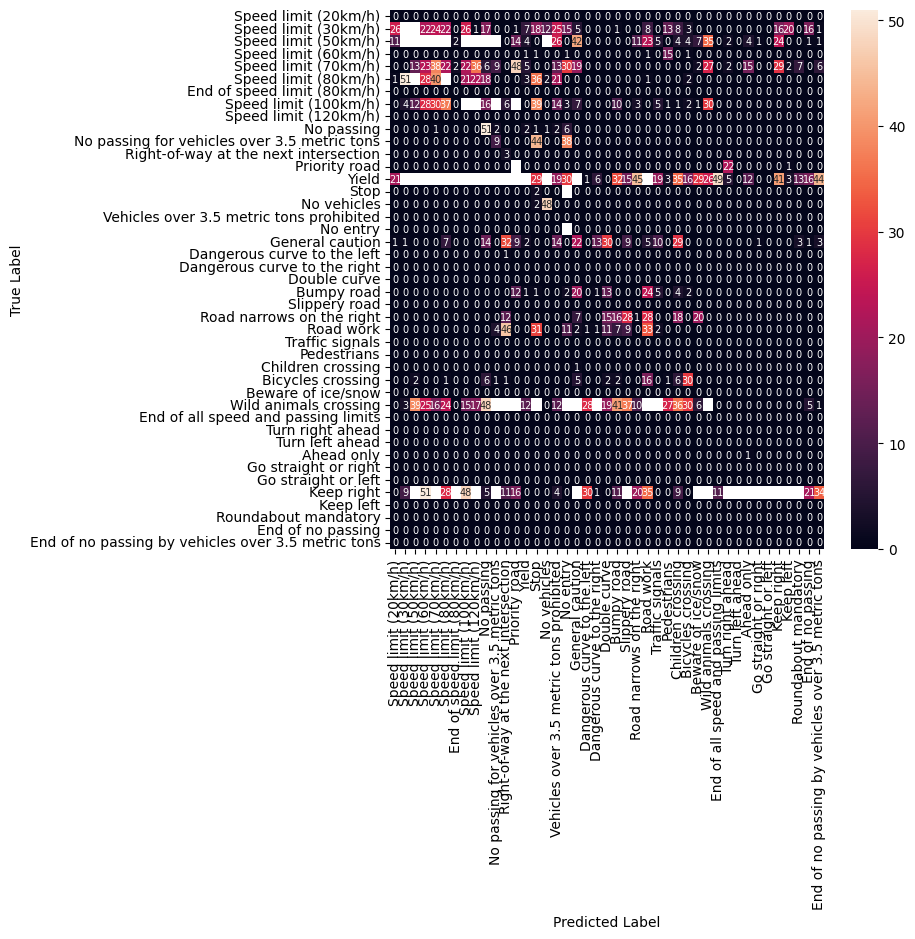

In [66]:
#Extract the model predictions on the test set (for confusion matrix building):
tf.random.set_seed(42)
np.random.seed(42)

pred = model.predict(X_test)
#pred

#Convert label matrices to index values for confustion matrix:
y_preds = []
for i in range(len(pred)):
  y_preds.append(np.argmax(pred[i]))
#y_preds

y_act = []
for i in range(len(y_test)):
  y_act.append(np.argmax(y_test[i]))
#y_act

#import torch
y_act =torch.Tensor(y_act)
y_preds = torch.Tensor(y_preds)

#Plot heatmap of classification results (masking values >50 to point out misclassifications)
fig, ax = plt.subplots(figsize=(7,7))
corr = confusion_matrix(y_preds, y_act)
names = signnames.values()
#corr/np.sum(corr), fmt='.1%'
sns.heatmap(corr, annot=True,
            xticklabels=names,yticklabels=names, fmt='d',annot_kws={"size": 7},
            mask= corr >51)#,
            #cmap="Blues")

plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

In [73]:
#Improved LeNet-5 
tf.random.set_seed(42)
np.random.seed(42)
eps = 10

model2 = Sequential()
model2.add(Conv2D(filters=32, kernel_size=(5,5), activation='relu', padding='valid', input_shape=X_train.shape[1:]))
model2.add(Conv2D(filters=32, kernel_size=(5,5), activation='relu', padding='valid'))
model2.add(AveragePooling2D(pool_size=(2,2),strides=2,padding='valid',data_format=None,)) #is this right?
model2.add(Dropout(rate=0.25)) 
model2.add(Conv2D(filters=64, kernel_size=(5,5), activation='relu', padding='valid'))
model2.add(Conv2D(filters=64, kernel_size=(5,5), activation='relu', padding='valid'))
model2.add(AveragePooling2D(pool_size=(2,2),strides=2,padding='valid',data_format=None,)) #is this right?
model2.add(Dropout(rate=0.25)) 
model2.add(Flatten())
model2.add(Dense(120, activation='relu'))
model2.add(Dropout(rate=0.25)) 
model2.add(Dense(84, activation='relu'))
model2.add(Dense(43, activation='softmax'))

#Compile the model:
model2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

#Fit the model:
#history2 = model2.fit(X_train, y_train, batch_size=32, epochs=eps, validation_data=(X_val, y_val))
history2 = model.fit(train_generator, batch_size=32, epochs=eps, validation_data=val_generator)

Epoch 1/10
1088/1088 [==============================] - 32s 29ms/step - loss: 1.1010 - accuracy: 0.6374 - val_loss: 2.1926 - val_accuracy: 0.4488
Epoch 2/10
1088/1088 [==============================] - 32s 29ms/step - loss: 1.0827 - accuracy: 0.6441 - val_loss: 2.2072 - val_accuracy: 0.4370
Epoch 3/10
 342/1088 [========>.....................] - ETA: 20s - loss: 1.0944 - accuracy: 0.6381

KeyboardInterrupt: ignored

In [71]:
model2.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_20 (Conv2D)          (None, 28, 28, 32)        2432      
                                                                 
 conv2d_21 (Conv2D)          (None, 24, 24, 32)        25632     
                                                                 
 average_pooling2d_18 (Avera  (None, 12, 12, 32)       0         
 gePooling2D)                                                    
                                                                 
 dropout_3 (Dropout)         (None, 12, 12, 32)        0         
                                                                 
 conv2d_22 (Conv2D)          (None, 8, 8, 64)          51264     
                                                                 
 conv2d_23 (Conv2D)          (None, 4, 4, 64)          102464    
                                                      

       loss  accuracy  val_loss  val_accuracy
0  1.237059  0.595391  2.218009      0.418821
1  1.215868  0.597776  2.221702      0.417007
2  1.196481  0.604931  2.313696      0.409977
3  1.189832  0.609558  2.358098      0.427891
4  1.173987  0.613495  2.209372      0.452608


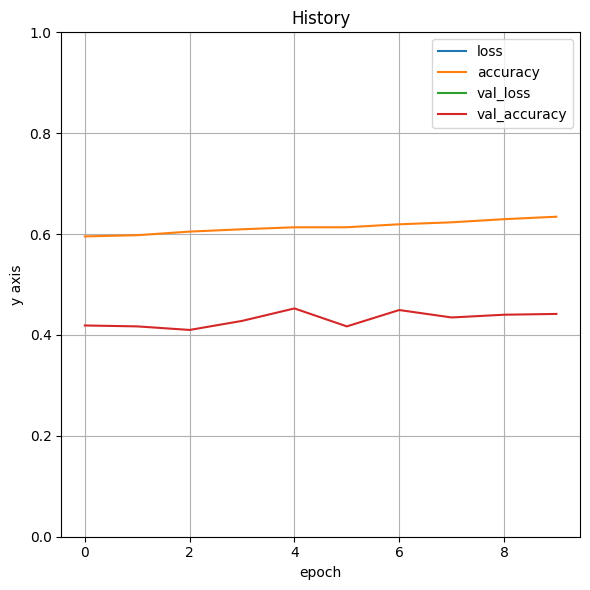

In [72]:
#Plot the loss and accuracy v. Epoch
df=pd.DataFrame(history2.history)
print(df.head())

fig,ax=plt.subplots(figsize=(6,6))
ax.plot(df['loss'], label='loss')
ax.plot(df['accuracy'], label='accuracy')
ax.plot(df['val_loss'], label='val_loss')
ax.plot(df['val_accuracy'], label='val_accuracy')
ax.legend(loc=0)
ax.set_title('History')
ax.set_xlabel('epoch')
ax.set_ylabel('y axis')
ax.set_ylim(0,1)
ax.grid()
plt.tight_layout()
plt.show()

In [ ]:
#Extract the model predictions on the test set (for confusion matrix building):
tf.random.set_seed(42)
np.random.seed(42)

pred = model2.predict(X_test)
#pred

#Convert label matrices to index values for confustion matrix:
y_preds = []
for i in range(len(pred)):
  y_preds.append(np.argmax(pred[i]))
#y_preds

y_act = []
for i in range(len(y_test)):
  y_act.append(np.argmax(y_test[i]))
#y_act

#import torch
y_act =torch.Tensor(y_act)
y_preds = torch.Tensor(y_preds)

#Plot heatmap of classification results (masking values >50 to point out misclassifications)
fig, ax = plt.subplots(figsize=(7,7))
corr = confusion_matrix(y_preds, y_act)
names = signnames.values()
#corr/np.sum(corr), fmt='.1%'
sns.heatmap(corr, annot=True,
            xticklabels=names,yticklabels=names, fmt='d',annot_kws={"size": 7},
            mask= corr >51)#,
            #cmap="Blues")

plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

In [ ]:
type(X_train_enlarged)


In [ ]:
#Convert to tensor
X_train_enlarged_tensor = tf.convert_to_tensor(X_train_enlarged)
#X_val_tensor
#X_test_tensor
print(type(X_train_enlarged_tensor), type(X_val_tensor), type(X_test_tensor))

In [ ]:
#THIS CRASHES DUE TO TOO MUCH RAM! NEED MORE COMPUTATIONAL POWER FOR RESCALING IMAGES

#def process_images(image):
#  image = tf.image.resize(image, (277,277))
#  return image

#X_train_alex = tf.cast(X_train_enlarged_tensor, tf.int32)
#X_train_alex.map(process_images)
#X_train_alex.shape
#X_train_alex = torch.Tensor(X_train_enlarged)
#X_train_alex.map(process_images)
#y_preds = torch.Tensor(y_preds)


#for i in range(len(X_train_enlarged)):
#  X_train_alex = X_train_alex.expand(tf.image.resize(X_train_enlarged[i], (277,277)))
#  X_train_enlarged_tensor[i] = tf.image.resize(X_train_enlarged_tensor[i], (277,277))
#X_train_alex = tf.image.resize(X_train_enlarged_tensor[1], (277,277))

'''
import cv2

#img = cv2.resize(X_train[1], dsize=(277,277), interpolation=cv2.INTER_CUBIC)
#X_train[1]
#img
#plt.imshow(img)

#Convert images to (277,277,3) for alexnet:
rehape = lambda x: cv2.resize(x, dsize=(277,277), interpolation=cv2.INTER_CUBIC)
X_train_resized = np.array([rehape(i) for i in X_train])

#for i in range(len(X_test)):
#  X_test_resized.append(cv2.resize(X_test[i], dsize=(277,277), interpolation=cv2.INTER_CUBIC))
  #y_test_resized = cv2.resize(X_test[i], dsize=(277,277), interpolation=cv2.INTER_CUBIC)


#Show Comparison of Images:
plt.subplot(1,2,1)
z = 4004
plt.imshow(X_train_resized[1])
plt.subplot(1,2,2)
#plt.imshow(X_train[int(z/2)])
plt.imshow(X_train[1])
'''

In [ ]:
#CANT RUN ALEXNET DUE TO LACK OF COMPUTING POWER FOR RESCALING IMAGES ABOVE
'''
tf.random.set_seed(42)
np.random.seed(42)
eps = 10

#AlexNet:

model=keras.models.Sequential([
    keras.layers.Conv2D(filters=128, kernel_size=(11,11), strides=(4,4), activation='relu', input_shape=X_train.shape[1:]),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(2,2)),
    keras.layers.Conv2D(filters=256, kernel_size=(5,5), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3,3)),
    keras.layers.Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=256, kernel_size=(1,1), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=256, kernel_size=(1,1), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(2,2)),
    keras.layers.Flatten(),
    keras.layers.Dense(1024,activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(1024,activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(43,activation='softmax')  
])

#Compile the model:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

#Fit the model:
history3 = model.fit(X_train, y_train, batch_size=32, epochs=eps, validation_data=(X_val, y_val))
'''


In [ ]:
'''
#ATTEMPTING TO TUNE HYPERPARAMETERS OF BASELINE MODEL HERE!!!
#https://www.analyticsvidhya.com/blog/2021/05/tuning-the-hyperparameters-and-layers-of-neural-network-deep-learning/

# Import packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from keras.models import Sequential
from keras.layers import Dense, BatchNormalization, Dropout
from keras.optimizers import Adam, SGD, RMSprop, Adadelta, Adagrad, Adamax, Nadam, Ftrl
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.wrappers.scikit_learn import KerasClassifier
from math import floor
from sklearn.metrics import make_scorer, accuracy_score
from bayes_opt import BayesianOptimization
from sklearn.model_selection import StratifiedKFold
from keras.layers import LeakyReLU
LeakyReLU = LeakyReLU(alpha=0.1)
import warnings
warnings.filterwarnings('ignore')
pd.set_option("display.max_columns", None)

# Make scorer accuracy
score_acc = make_scorer(accuracy_score)

# Create function
def nn_cl_bo(neurons, activation, optimizer, learning_rate,  batch_size, epochs ):
    optimizerL = ['SGD', 'Adam', 'RMSprop', 'Adadelta', 'Adagrad', 'Adamax', 'Nadam', 'Ftrl','SGD']
    optimizerD= {'Adam':Adam(lr=learning_rate), 'SGD':SGD(lr=learning_rate),
                 'RMSprop':RMSprop(lr=learning_rate), 'Adadelta':Adadelta(lr=learning_rate),
                 'Adagrad':Adagrad(lr=learning_rate), 'Adamax':Adamax(lr=learning_rate),
                 'Nadam':Nadam(lr=learning_rate)}
    activationL = ['sigmoid', 'softplus', 'softsign', 'tanh', 'selu', 'relu']
    neurons = round(neurons)
    activation = activationL[round(activation)]
    batch_size = round(batch_size)
    epochs = round(epochs)
    def nn_cl_fun():
        opt = Adam(lr = learning_rate)
        nn = Sequential()
        nn.add(Dense(neurons, input_dim=10, activation=activation))
        nn.add(Dense(neurons, activation=activation))
        nn.add(Dense(1, activation='sigmoid'))
        nn.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
        return nn
    es = EarlyStopping(monitor='accuracy', mode='max', verbose=0, patience=20)
    nn = KerasClassifier(build_fn=nn_cl_fun, epochs=epochs, batch_size=batch_size,
                         verbose=0)
    kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=123)
    score = cross_val_score(nn, X_train, y_train, scoring=score_acc, cv=kfold, fit_params={'callbacks':[es]}).mean()
    return score



# Set paramaters
params_nn ={
    'neurons': (10, 100),
    'activation':(0, 9),
    'optimizer':(0,7),
    'learning_rate':(0.01, 1),
    'batch_size':(200, 1000),
    'epochs':(20, 100)
}
# Run Bayesian Optimization
nn_bo = BayesianOptimization(nn_cl_bo, params_nn, random_state=111)
nn_bo.maximize(init_points=25, n_iter=4)

#Here are the best hyperparameters.

params_nn_ = nn_bo.max['params']
activationL = ['relu', 'sigmoid', 'softplus', 'softsign', 'tanh', 'selu',
               'elu', 'exponential', LeakyReLU,'relu']
params_nn_['activation'] = activationL[round(params_nn_['activation'])]
params_nn_
'''

In [ ]:
'''
parameters = {'batch_size': [25, 32],
          'epochs': [100, 500],
          'optimizer': ['adam', 'rmsprop']}
grid_search = GridSearchCV(estimator = classifier,
                       param_grid = parameters,
                       scoring = 'accuracy',
                       cv = 10)
grid_search = grid_search.fit(X_train, y_train)
'''